# Import libraries

In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
import seaborn as sns

# Import dataset

Import and read dataset:

In [5]:
trainingData = pd.read_csv('csv/trainingData.csv')
trainingData

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,100,100,100,100,100,100,100,100,100,100,...,100,-7541.2643,4.864921e+06,2,1,106,2,2,23,1371713733
1,100,100,100,100,100,100,100,100,100,100,...,100,-7536.6212,4.864934e+06,2,1,106,2,2,23,1371713691
2,100,100,100,100,100,100,100,-97,100,100,...,100,-7519.1524,4.864950e+06,2,1,103,2,2,23,1371714095
3,100,100,100,100,100,100,100,100,100,100,...,100,-7524.5704,4.864934e+06,2,1,102,2,2,23,1371713807
4,100,100,100,100,100,100,100,100,100,100,...,100,-7632.1436,4.864982e+06,0,0,122,2,11,13,1369909710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19932,100,100,100,100,100,100,100,100,100,100,...,100,-7485.4686,4.864875e+06,3,1,1,2,18,10,1371710683
19933,100,100,100,100,100,100,100,100,100,100,...,100,-7390.6206,4.864836e+06,1,2,140,2,18,10,1371710402
19934,100,100,100,100,100,100,100,100,100,100,...,100,-7516.8415,4.864889e+06,3,1,13,2,18,10,1371710921
19935,100,100,100,100,100,100,100,100,100,100,...,100,-7537.3219,4.864896e+06,3,1,113,2,18,10,1371711049


# Clean data

## Drop duplicates

Some duplicates are present in the dataset:

In [6]:
trainingData.drop_duplicates(inplace=True)
# How many rows after dropping duplicates?
print(len(trainingData))

19300


## Missing values

There are no missing values in the dataset:

In [7]:
trainingData.isnull().sum().sort_values(ascending=False)

WAP001       0
WAP349       0
WAP363       0
WAP362       0
WAP361       0
            ..
WAP172       0
WAP171       0
WAP170       0
WAP169       0
TIMESTAMP    0
Length: 529, dtype: int64

## Inconsistent data

Now lets check positions (LONGITUDE,LATITUDE) of the taken measurements:

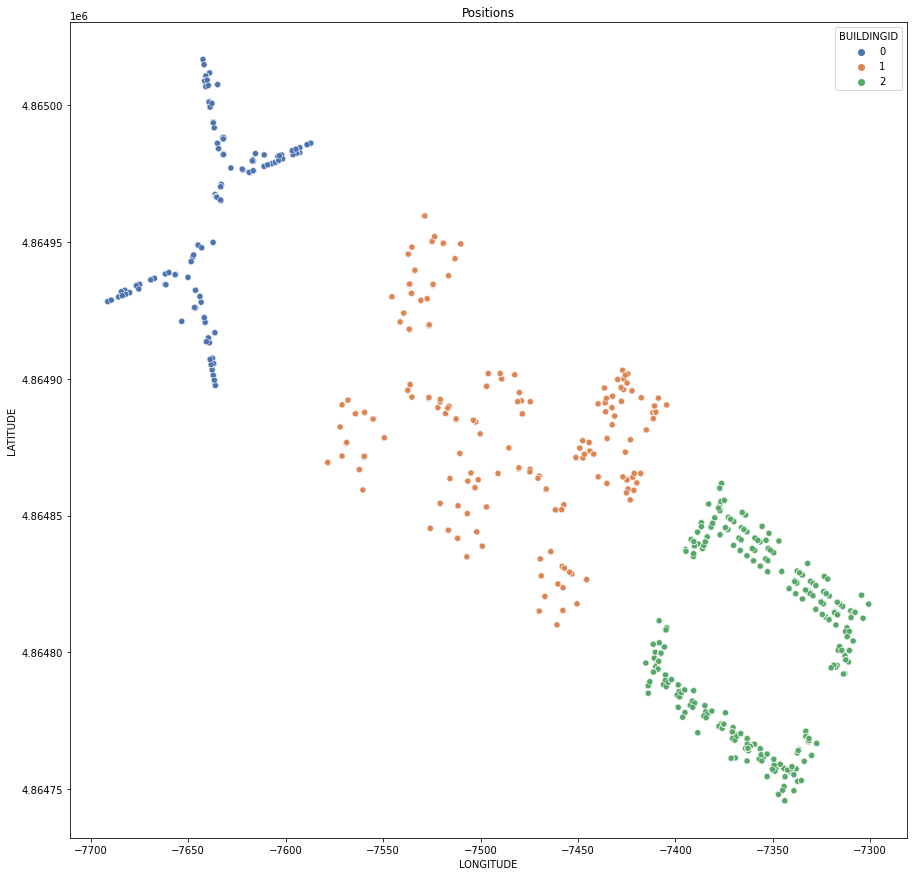

In [8]:
# show all positions of the buildings
data_pos = trainingData
plt.figure(figsize = (15,15))
plt.title("Positions")
plt.xlabel("LONGITUDE")
sns.scatterplot(data = data_pos, x = 'LONGITUDE', y = 'LATITUDE',hue='BUILDINGID',palette='deep')
plt.show()

There is possible data inconsistency here!
WAPs cannot belong to the building 0 and 2 at the same time. Lets find such records and exclude them.

Lets select WAP columns

In [9]:
wap_cols =[ col for col in trainingData.columns if col[0:3] == 'WAP'] 

Lets find WAPs that were detected both in building 0 and 2 in trainingData

In [10]:
# select common building range of WAP

common_blds =[0,2]

buildings_waps = {}
waps_common = []
#iterate through WAPs
for col in wap_cols:
    # select rows with signal <= 0 and detect their buildings scope
    buildings = trainingData[trainingData[col] <= 0]['BUILDINGID'].sort_values().unique()
    buildings_waps[col] = list(buildings)

# list of WAPs present in both buildings 0 and 2
for key in buildings_waps.keys():
    if buildings_waps[key] == common_blds:
        waps_common.append(key)
waps_common

['WAP018', 'WAP212', 'WAP305', 'WAP508']

Lets find out how often do these WAPs appear in buildings 0 and 2:

In [11]:
freq_0 = {}
freq_2 = {}
for col in waps_common:
    freq_0[col]=(len(trainingData[(trainingData.BUILDINGID == 0) & (trainingData[col] <= 0)]))
    freq_2[col]=(len(trainingData[(trainingData.BUILDINGID == 2) & (trainingData[col] <= 0)]))
print('Building 0: ',freq_0)
print('Building 2: ',freq_2)

Building 0:  {'WAP018': 86, 'WAP212': 2, 'WAP305': 9, 'WAP508': 13}
Building 2:  {'WAP018': 2, 'WAP212': 2, 'WAP305': 48, 'WAP508': 79}


The mean signal value for these WAPs is:

In [12]:
# signal mean value of common WAPs for buildings 0 and 2
signal_mean_0 = {}
signal_mean_2 = {}
for col in waps_common:
    signal_mean_0[col] = round(trainingData[(trainingData.BUILDINGID == 0) & (trainingData[col] <= 0)][col].mean(),1)
    signal_mean_2[col] = round(trainingData[(trainingData.BUILDINGID == 2) & (trainingData[col] <= 0)][col].mean(),1) 
print('Building 0: ',signal_mean_0)
print('Building 2: ',signal_mean_2)

Building 0:  {'WAP018': -89.3, 'WAP212': -96.0, 'WAP305': -95.4, 'WAP508': -91.0}
Building 2:  {'WAP018': -89.0, 'WAP212': -94.0, 'WAP305': -86.0, 'WAP508': -91.8}


Based on frequencies and mean values of signal we can make decision on which rows should be droppped. Most probably, WAP018  belongs to the bulding 0 and cannot be in the building 2. WAP305, WAP508 belong to the building 2
and cannot be in the building 0

In [13]:
rows_drop_0 = list(trainingData.query('(WAP018 <= 0) & (BUILDINGID == 2)').index)
rows_drop_2 = list(trainingData.query('((WAP305 <= 0) or (WAP508 <= 0)) & (BUILDINGID == 0)').index)

In [14]:
trainingData.drop(labels=rows_drop_0,axis=0,inplace=True)
trainingData.drop(labels=rows_drop_2,axis=0,inplace=True)

In case of WAP212, this WAP appears equaly frequent in buildings 0 and 2. The average signal level is almost the same. This feature should be dropped, because it is giving us inconsistent data. Lets save the column name to drop it during feature selection

In [15]:
col_inconsistent_drop = ['WAP212']

## User with most postion errors (Optional)

If needed , we can drop records made by particular users. 

In [16]:
# Select Users to drop:
users = [11]
# Set to True if you want to drop specific users:
drop_users = False

In [17]:
if drop_users:
    rows_drop_user = list(trainingData.query('USERID in 11').index)
    trainingData.drop(labels=rows_drop_user,axis=0,inplace=True)

# Export cleaned data

In [18]:
trainingData.to_csv('csv/cleaned/trainingData_clean.csv')